# Advanced Jobflow Tutorial
The tutorial has been written by [J. George](https://jageo.github.io/) (Federal Institute for Materials Research and Testing in Germany in Berlin, Friedrich Schiller University). Suggestions and corrections by A. Naik, C. Ertural, and A. S. Rosen have been included.

## Jobflow
We will use [jobflow](https://github.com/materialsproject/jobflow) to write and execute workflows on our local machines. One can also start these computations on supercomputers and convert the flows from jobflow to Workflows that can be executed with [Fireworks](https://materialsproject.github.io/fireworks/). This allows for parallel execution of jobs that are in the same workflow.

We recommend doing the basic jobflow tutorials [Five-minute Quickstart](https://materialsproject.github.io/jobflow/tutorials/1-quickstart.html), [Introdution to jobflow](https://materialsproject.github.io/jobflow/tutorials/2-introduction.html) and [Defining jobs in jobflow](https://materialsproject.github.io/jobflow/tutorials/3-defining-jobs.html) before starting with this tutorial.

The tutorial will cover the development of a workflow to compute the equation of state and of a workflow to compute vibrational properties (phonons). It aims at the computational materials science community rather than chemistry but the workflow development should not be  very different. The tutorial will assume background in solid-state chemistry and physics.

## Install All Relevant Software

We start by installing all relevant software. We will use jobflow but also two typical software from computational materials science. [ASE](https://gitlab.com/ase/ase) and [pymatgen](https://pymatgen.org/). [pymatgen](https://pymatgen.org/) works especially well together with jobflow as both have been developed in the context of the [Materials Project](https://materialsproject.org/).

In [147]:
%%capture
!pip install jobflow[strict]

In [148]:
%%capture
!pip install ase

In [149]:
%%capture
!pip install pymatgen

## Workflow to Compute the Equation of State (e.g., to Compute a Bulk Modulus)

In this first tutorial, we will build `flows` and `jobs` to automatize the computation of the equation of state. This tutorial has been inspired by the equation of state tutorial from ASE: [https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html](https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html).

Please also check out this nice paper that compares different equations of state: [K. Latimer, S. Dwaraknath, K. Mathew, D. Winston, K. A. Persson, npj Comput Mater 2018, 4, 40.](https://doi.org/10.1038/s41524-018-0091-x) You can use the different equations of state with the help of [pymatgen](https://github.com/materialsproject/pymatgen).


### How Does the Computation Work Without Workflow?
We will start by looking at how we would compute the results without workflow. To avoid needing large computing resources, we will choose a very fast [calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html) from ase (i.e., an object to compute energies, forces and stresses from ab initio theories or force fields for a given structure) and small unit cells during the computations. The exact method "Effective Medium Theory" will be introduced below.

Let's import `Maker`:

We will start by constructing a simple unit cell with the `Atoms` object in ASE: Ag in fcc structure type. The `Atoms` object in ASE is used to represent the structure. It can also be directly connected to electronic energies, forces and stresses when a calculator is added.

In [150]:
from ase.build import bulk

atoms = bulk("Ag", "fcc", 3.9)

In [151]:
print(atoms)

Atoms(symbols='Ag', pbc=True, cell=[[0.0, 1.95, 1.95], [1.95, 0.0, 1.95], [1.95, 1.95, 0.0]])


It is possible to visualize the structure.

<Axes: >

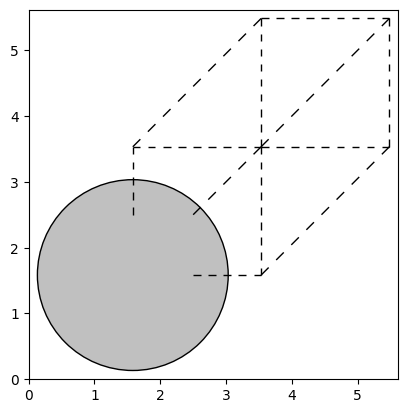

In [152]:
from ase.visualize.plot import plot_atoms
plot_atoms(atoms)

Besides using an ASE `Atoms` object, we will later on also use `Structure` objects from pymatgen. They are very handy as they can be easily converted to json which is used by jobflow to encode job outputs. There are conversion tools from the `Atoms` object to the `Structure` object available in pymatgen. Let's create a `Structure` object from an `Atoms` object. This converter will only convert the structural information but not information on the computations that can also be stored in the `Atoms` object.

In [153]:
from pymatgen.io.ase import AseAtomsAdaptor

structure = AseAtomsAdaptor().get_structure(atoms)
print(structure)
print(structure.as_dict())

Full Formula (Ag1)
Reduced Formula: Ag
abc   :   2.757716   2.757716   2.757716
angles:  60.000000  60.000000  60.000000
pbc   :       True       True       True
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ag      0    0    0
{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[0.0, 1.95, 1.95], [1.95, 0.0, 1.95], [1.95, 1.95, 0.0]], 'pbc': (True, True, True), 'a': 2.7577164466275352, 'b': 2.7577164466275352, 'c': 2.7577164466275352, 'alpha': 59.99999999999999, 'beta': 59.99999999999999, 'gamma': 59.99999999999999, 'volume': 14.829749999999999}, 'sites': [{'species': [{'element': 'Ag', 'occu': 1}], 'abc': [0.0, 0.0, 0.0], 'xyz': [0.0, 0.0, 0.0], 'label': 'Ag', 'properties': {}}]}


#### Effective Medium Theory (EMT)
To calculate energies, forces and stresses, we will use effective-medium theory as described in [K. W. Jacobsen, J. K. Norskov, M. J. Puska, Phys. Rev. B 1987, 35, 7423–7442.
](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.35.7423) We mainly use this approximation to be able to perform the computations without high-performance computers and still have reasonable results for simple solids such as Ag. The method is based on an ansatz that assumes that the total electron density can be expressed as a sum of the electron densities of individual atoms. The electron densities of the individual atoms are calculated separately assuming that each atom is embedded in a homogeneous electron gas. It's not necessary to understand this approximation in detail to perform the exercises. Typically, our workflows in computational materials science use DFT (e.g., as implemented in VASP).


Let's add the EMT calculator to the `Atoms` object.

In [154]:
from ase.calculators.emt import EMT

atoms.calc = EMT()

#### Structure Optimization
We need a structural optimization for the equation of state workflow. To do so, we will use a standard optimizer from ASE ([BFGS](https://databases.fysik.dtu.dk/ase/ase/optimize.html#ase.optimize.BFGS)) here to perform the optimization. We add an additional `Filter`, the [ExpCellFilter](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-expcellfilter-class), to also optimize the cell parameters and not only the atomic positions.

In [155]:
from ase.optimize import BFGS
from ase.constraints import ExpCellFilter

print(atoms)
opt = BFGS(ExpCellFilter(atoms))
opt.run(fmax=0.00001)
print(atoms)

Atoms(symbols='Ag', pbc=True, cell=[[0.0, 1.95, 1.95], [1.95, 0.0, 1.95], [1.95, 1.95, 0.0]], calculator=EMT(...))
      Step     Time          Energy         fmax
BFGS:    0 09:09:36        0.088477        1.5173
BFGS:    1 09:09:36        0.018361        0.6601
BFGS:    2 09:09:36       -0.000016        0.0864
BFGS:    3 09:09:36       -0.000365        0.0064
BFGS:    4 09:09:36       -0.000367        0.0001
BFGS:    5 09:09:36       -0.000367        0.0000
Atoms(symbols='Ag', pbc=True, cell=[[-2.298712018099952e-16, 2.0317762972959157, 2.0317762972959117], [2.0317762972959135, 2.3373590085817006e-15, 2.0317762972959117], [2.031776297295913, 2.0317762972959126, 1.2589072243282675e-16]], calculator=EMT(...))


We have printed the `Atoms` object before and after the optimization. As you can see, the cell parameters have changed. The atomic positions will typically not change due to the high symmetry of the chosen structure.

Next, we are printing the results for energies, forces and stresses.

In [156]:
print(atoms.calc.results)

{'energy': -0.00036686253946172087, 'energies': array([-0.00036686]), 'free_energy': -0.00036686253946172087, 'forces': array([[0., 0., 0.]]), 'stress': array([-3.44910465e-09, -3.44910586e-09, -3.44910471e-09,  5.07608054e-16,
        1.58738221e-17, -7.53100562e-17])}


#### Computing Energies and Volumes for the Equation of State
After this full optimization of the structure, we will now scale the cell parameters to get the energy-volume curve. At each of the scaled structures, we will perform an optimization with constant volume and evaluate the energy of the structures at the different volumes. We start with current cell parameters after the full optimization:

In [157]:
cell = atoms.get_cell()
print(cell)

Cell([[-2.298712018099952e-16, 2.0317762972959157, 2.0317762972959117], [2.0317762972959135, 2.3373590085817006e-15, 2.0317762972959117], [2.031776297295913, 2.0317762972959126, 1.2589072243282675e-16]])


We will first test the scaling with a volume change of 1%:

In [158]:
new_cell = cell * 1.01
print(new_cell)
print(cell)

[[-2.32169914e-16  2.05209406e+00  2.05209406e+00]
 [ 2.05209406e+00  2.36073260e-15  2.05209406e+00]
 [ 2.05209406e+00  2.05209406e+00  1.27149630e-16]]
Cell([[-2.298712018099952e-16, 2.0317762972959157, 2.0317762972959117], [2.0317762972959135, 2.3373590085817006e-15, 2.0317762972959117], [2.031776297295913, 2.0317762972959126, 1.2589072243282675e-16]])


Now, we will perform the full energy volume-curve computation. The optimizations that we will perform will now be at constant volume. After the optimization, we are collecting the volumes and energies.

In [159]:
import numpy as np
from ase.io.trajectory import Trajectory
from copy import deepcopy

cell = atoms.get_cell()

volumes = []
energies = []
for x in [0.95, 0.97, 0.99, 1.00, 1.01, 1.03, 1.05]:
    optimized_atoms = deepcopy(atoms)
    optimized_atoms.set_cell(cell * x, scale_atoms=True)
    opt = BFGS(ExpCellFilter(optimized_atoms, constant_volume=True), logfile="./optimization.log")
    opt.run(fmax=0.00001)
    volumes.append(optimized_atoms.get_volume())
    energies.append(optimized_atoms.get_potential_energy())

print(volumes)
print(energies)

[14.382304526892272, 15.309918086569299, 16.27658340882234, 16.774812103096398, 17.283105684632318, 18.330290104980214, 19.418941860846967]
[0.14168852968516887, 0.04714559046761835, 0.004531478880869244, -0.00036686253946172087, 0.004180145974302718, 0.03765776040276947, 0.0980053988235543]


#### Plotting and Evaluating the Equation of State
We will now plot the equation of state:

0.6242845498684262 eV Angstrom**(-3)
100.02141105258441 GPa


<Axes: title={'center': 'sj: E: -0.000 eV, V: 16.776 Å$^3$, B: 100.021 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

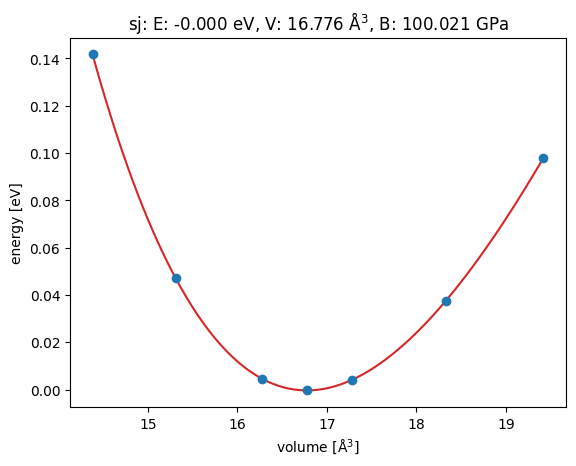

In [160]:
from ase.units import kJ
from ase.eos import EquationOfState

eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B, 'eV Angstrom**(-3)')
print(B / kJ * 1.0e24, 'GPa')
eos.plot('outputs/Ag-eos.png')

The result is acceptable for us. You can compare the result from EMT to DFT results here: [https://materialsproject.org/materials/mp-124?chemsys=Ag#equations_of_state](https://materialsproject.org/materials/mp-124?chemsys=Ag#equations_of_state) The volume from EMT is different by 1 Angstrom³ and Bulk modulus from eMT is off by a factor of 10 depending on the equation of state.

#### Structure of the Workflow

We now have a workflow that starts with full structural optimization. After the structural optimization, structures with different volumes have to be created. Then, several structural optimizations with constant volume can be started. They are independent of each other and could run in parallel. At the very end, energies and volumes from these constant-volume optimizations are collected and the equation of state is fitted. An illustration of the workflow follows.

![Workflow](./workflow.png)

### Workflow Implementation (Equation of State)
Jobflow implements `Job` objects that are connected to a `Flow`. We typically use the `Maker` class from Jobflow to create jobs and flows. [There is also a tutorial on how to write a Maker](https://materialsproject.github.io/jobflow/tutorials/4-generalized-makers.html). A `Job` is an entity that can be executed independently. We therefore have four different job types to write for the workflow above: a full structural optimization, a job to create structures with different volumes, a structural optimization with the constraint of constant volume, and a job that plots and summarizes the results for the database. As the full structural optimization and the structural optimization with the constraint of constant volume are so similar, we will write a combined class inheriting from `Maker` class to create these jobs.

#### Structural Optimization (Job)

Let's work on an atomic job to optimize the structure. We will use a `Structure` object to carry the structural information as it can be easily transformed into json. We need the json format as we will save our results in databases that build upon the json format. Serialization is more complicated for an `Atoms` object. Check out [https://materialsproject.github.io/maggma/concepts](maggma) to learn more.

To write an atomic job in jobflow, we have to inherit from the `Maker` class and adapt the `make` method. You can find more about jobs here: [https://materialsproject.github.io/jobflow/tutorials/3-defining-jobs.html](https://materialsproject.github.io/jobflow/tutorials/3-defining-jobs.html). Please don't forget to add the decorators (e.g., `@dataclass`) as they are central for the execution of the workflow.  The decorator `@dataclass` will add special methods to the class. See here for more info: [https://docs.python.org/3/library/dataclasses.html](https://docs.python.org/3/library/dataclasses.html)

In [161]:
from jobflow.core.maker import Maker

We will write a job `OptimizeJob` which inherits from `Maker` and implement the `make` method. We add a `name` to the maker which will later on help us identify which job is running. The `make` method will take a structure as an input.

In [162]:
from dataclasses import dataclass
from jobflow import job, Maker
from pymatgen.core.structure import Structure


@dataclass
class OptimizeJob(Maker):
    """
    Class to carry out a full optimization of a structure with the EMT calculator

    Parameters
    ----------
    name
        Name of the job.
    """
    name: str = "EMT-Optimization"

    @job
    def make(self, structure: Structure):
        pass

In the next step, we simply add steps to perform the optimization. Thus, we take the same classes, methods and functions as before:

In [163]:
from dataclasses import dataclass
from jobflow import job
from pymatgen.core.structure import Structure


@dataclass
class OptimizeJob(Maker):
    """
    Class to carry out a full optimization of a structure with the EMT calculator

    Parameters
    ----------
    name
        Name of the job.
    """
    name: str = "EMT-Optimization"

    @job
    def make(self, structure: Structure):
        adaptor = AseAtomsAdaptor()
        atoms = adaptor.get_atoms(structure)  # get an atoms object
        atoms.calc = EMT()  # add emt as a calculator

        opt = BFGS(ExpCellFilter(atoms), logfile="./optimization.log")  # optimize the structure including cell parameters
        opt.run(fmax=0.00001)  # run the optimization


We have now built a Maker to optimize the structure. We might want to add `fmax` as a parameter of our `Maker` to change the default values. We will not do this for all potential settings as it just takes a lot of time to implement... It's possible to summarize such settings within one dict, e.g. called `optimize_kwargs`.

In [164]:
@dataclass
class OptimizeJob(Maker):
    """
    Class to carry out a full optimization of a structure with the EMT calculator

    Parameters
    ----------
    name
        Name of the job.
    fmax
        float that determines the forces after optimization
    """
    name: str = "EMT-Optimization"
    fmax: float = 0.00001

    @job
    def make(self, structure: Structure):
        adaptor = AseAtomsAdaptor()
        atoms = adaptor.get_atoms(structure)
        atoms.calc = EMT()
        opt = BFGS(ExpCellFilter(atoms), logfile="./optimization.log")
        opt.run(fmax=self.fmax)


We will add another parameter `constant_volume` to be able to do a constant volume optimization with the same maker.


To be able to connect different interdependent jobs, we also need to save our results (method should return the results we want to use further down the line) so that we can transfer our results between jobs.  For now, it will be enough to save the optimized structure and the energy at the end. You can also save forces, stresses and so on... Typically, a schema based on [Pydantic](https://docs.pydantic.dev/latest/) is developed to save the results. This is again just a lot of work and will not help us to understand the automation itself. It's again just important that all outputs can be serialized to a json.

In [165]:
@dataclass
class OptimizeJob(Maker):
    """
    Class to carry out a full optimization of an atoms object

    Parameters
    ----------
    name
        Name of the job.
    fmax
        float that determines the forces after optimization
    constant_volume
        bool that if true will enforce an optimization with constant volume
    """
    name: str = "EMT-Optimization"
    fmax: float = 0.00001
    constant_volume: bool = False

    @job
    def make(self, structure: Structure):
        adaptor = AseAtomsAdaptor()
        atoms = adaptor.get_atoms(structure)
        atoms.calc = EMT()
        opt = BFGS(ExpCellFilter(atoms, constant_volume=self.constant_volume), logfile="./optimization.log")
        opt.run(fmax=self.fmax)

        out_structure = adaptor.get_structure(atoms)

        results = {}
        results["optimized_structure"] = out_structure
        results["input_structure"] = structure
        results["energy"] = atoms.get_potential_energy()
        return results

For test purposes, we will simply now chain two optimizations, put them in a Flow (i.e., the object for workflows) and see what happens. We also always have to define an output for the flow. Very often, this is the output of the last job in the flow. We will use `run_locally` to execute the jobs locally. atomate2 has tutorials on how to [transfer such jobs to Fireworks](https://materialsproject.github.io/atomate2/user/fireworks.html) or [how to run them with a job script](https://materialsproject.github.io/atomate2/user/running-workflows.html).

In [166]:
from jobflow.managers.local import run_locally
from jobflow import Flow

atoms = bulk("Ag", "fcc", 4)
structure = AseAtomsAdaptor().get_structure(atoms)
maker_fullopt = OptimizeJob()
maker_opt_constant_vol = OptimizeJob(constant_volume=True)
job1 = maker_fullopt.make(structure=structure)
job2 = maker_opt_constant_vol.make(structure=job1.output["optimized_structure"])

flow = Flow([job1, job2], output=job2.output)

response = run_locally(flow)
print(response)


2023-06-05 09:09:36,946 INFO Started executing jobs locally
2023-06-05 09:09:36,952 INFO Starting job - EMT-Optimization (4bba1d50-fdff-4ae3-ade0-a9a8d97872e8)
2023-06-05 09:09:37,125 INFO Finished job - EMT-Optimization (4bba1d50-fdff-4ae3-ade0-a9a8d97872e8)
2023-06-05 09:09:37,127 INFO Starting job - EMT-Optimization (43a2da5a-5cce-4d1e-951c-8311b2712bd6)
2023-06-05 09:09:37,179 INFO Finished job - EMT-Optimization (43a2da5a-5cce-4d1e-951c-8311b2712bd6)
2023-06-05 09:09:37,180 INFO Finished executing jobs locally
{'4bba1d50-fdff-4ae3-ade0-a9a8d97872e8': {1: Response(output={'optimized_structure': Structure Summary
Lattice
    abc : 2.87336550651202 2.8733655065120205 2.87336550651202
 angles : 59.99999999999999 60.00000000000001 59.99999999999999
 volume : 16.774810547282314
      A : -1.0240902968258463e-16 2.031776234482168 2.0317762344821686
      B : 2.0317762344821686 2.323574183069503e-17 2.0317762344821686
      C : 2.0317762344821686 2.031776234482168 -2.8552862920234554e-17


As you can see, this works. Of course, this is not very useful here but could be useful, for example, for DFT optimizations, where typically at least two full structural optimizations have to be started due to basis set effects. Btw, you can also create folders for each atomic job in your workflow by using the parameter `create_folders` from `run_locally`.

#### Create Structures with Different Volumes and Start the Constant-Volume Optimizations (Job)
We now need to build a job that creates structures with different volumes and starts the optimizations with constant volume.

We will start by using a job that is called `get_ev_curve`. It will replace itself with a `Response` object that will start a completely new flow or job. As outputs, we will collect all optimized structures and the corresponding energies! We will reuse our maker `OptimizeJob` from above.

In [167]:
from jobflow import Response, job


@job
def get_ev_curve(structure: Structure, volumes=[0.95, 0.97, 0.99, 1.00, 1.01, 1.03, 1.05]):
    groundstate_vol = structure.volume
    const_vol_maker = OptimizeJob(constant_volume=True)
    job_list = []
    outputs = {
        "optimized_structures": [],
        "energies": [],
    }
    for vol_inc in volumes:
        struct_here = deepcopy(structure)
        struct_here.scale_lattice(groundstate_vol * vol_inc)
        relax_job = const_vol_maker.make(struct_here)
        job_list.append(relax_job)
        outputs["optimized_structures"].append(relax_job.output["optimized_structure"])
        outputs["energies"].append(relax_job.output["energy"])
    return Response(replace=Flow(job_list, output=outputs))



We can now build a flow including the full optimization and the job to change the volumes and start the constant-volume optimizations. We need to transfer the optimized structure to the second job. Please remember that `job1.output["optimized_structure"]` is a reference to the future output. It can only be accessed if the job has been already executed. You cannot access this output while generating the flow for the first time.

In [168]:
atoms = bulk("Ag", "fcc", 4)
structure = AseAtomsAdaptor().get_structure(atoms)
maker_fullopt = OptimizeJob()
maker_opt_constant_vol = OptimizeJob(constant_volume=True)
job1 = maker_fullopt.make(structure=structure)
job2 = get_ev_curve(structure=job1.output["optimized_structure"])

flow = Flow([job1, job2], output=job2.output)

response = run_locally(flow)

2023-06-05 09:09:37,207 INFO Started executing jobs locally
2023-06-05 09:09:37,210 INFO Starting job - EMT-Optimization (f39c0132-a1b5-4633-a353-431bdd673e3c)
2023-06-05 09:09:37,327 INFO Finished job - EMT-Optimization (f39c0132-a1b5-4633-a353-431bdd673e3c)
2023-06-05 09:09:37,329 INFO Starting job - get_ev_curve (f6997120-2a52-400a-9db2-d0110d35e81e)
2023-06-05 09:09:37,354 INFO Finished job - get_ev_curve (f6997120-2a52-400a-9db2-d0110d35e81e)
2023-06-05 09:09:37,361 INFO Starting job - EMT-Optimization (d3726b72-7edb-4125-b58a-d7d81bd5d73b)
2023-06-05 09:09:37,399 INFO Finished job - EMT-Optimization (d3726b72-7edb-4125-b58a-d7d81bd5d73b)
2023-06-05 09:09:37,401 INFO Starting job - EMT-Optimization (1e6021ab-3006-4d2e-8ec7-52abe55cde6e)
2023-06-05 09:09:37,442 INFO Finished job - EMT-Optimization (1e6021ab-3006-4d2e-8ec7-52abe55cde6e)
2023-06-05 09:09:37,443 INFO Starting job - EMT-Optimization (5aac47cf-604b-4372-92d8-e56941601e88)
2023-06-05 09:09:37,478 INFO Finished job - EMT-

#### Summary Job

We will now write a job `get_results_ev_curve` that will collect all results, make plots and store the information in a database. It will start from a list of structures and energies and then plot an energy-volume curve to a file and return the most important results.

In [169]:
@job
def get_results_ev_curve(list_structures, list_energies):
    list_volumes = []
    for struct in list_structures:
        list_volumes.append(struct.volume)

    eos = EquationOfState(list_volumes, list_energies)
    v0, e0, B = eos.fit()
    eos.plot('eos.png')

    results = {}
    results["V0"] = v0
    results["e0"] = e0
    results["B"] = B

    return Response(results)

#### Full Workflow

Now, we combine all jobs to a larger workflow and check out the output. To do so, we will need a universally unique identifier (uuid). In our case, this will be te one of the last job. Again, we also need to transfer all information between the jobs correctly.

2023-06-05 09:09:37,647 INFO Started executing jobs locally
2023-06-05 09:09:37,650 INFO Starting job - EMT-Optimization (aa60306e-7480-4f55-8ce4-28062737c6cc)
2023-06-05 09:09:37,772 INFO Finished job - EMT-Optimization (aa60306e-7480-4f55-8ce4-28062737c6cc)
2023-06-05 09:09:37,773 INFO Starting job - get_ev_curve (89574327-8451-44a3-abbd-216ce056fb43)
2023-06-05 09:09:37,794 INFO Finished job - get_ev_curve (89574327-8451-44a3-abbd-216ce056fb43)
2023-06-05 09:09:37,800 INFO Starting job - EMT-Optimization (7269cfed-a7d2-4659-b596-2b0ea0b780e1)
2023-06-05 09:09:37,833 INFO Finished job - EMT-Optimization (7269cfed-a7d2-4659-b596-2b0ea0b780e1)
2023-06-05 09:09:37,834 INFO Starting job - EMT-Optimization (b065fe3c-1bcb-40e0-8095-4d2543f5b800)
2023-06-05 09:09:37,866 INFO Finished job - EMT-Optimization (b065fe3c-1bcb-40e0-8095-4d2543f5b800)
2023-06-05 09:09:37,867 INFO Starting job - EMT-Optimization (e4161919-493d-4ffe-a723-f5fb86826ccc)
2023-06-05 09:09:37,901 INFO Finished job - EMT-

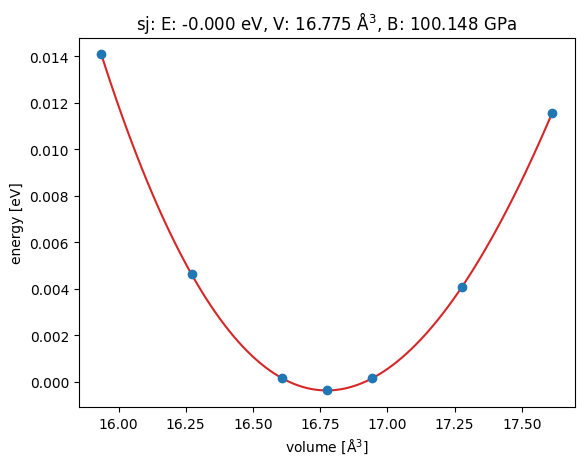

In [170]:
atoms = bulk("Ag", "fcc", 4)
structure = AseAtomsAdaptor().get_structure(atoms)
maker_fullopt = OptimizeJob()
job1 = maker_fullopt.make(structure=structure)
job2 = get_ev_curve(structure=job1.output["optimized_structure"])
job3 = get_results_ev_curve(list_structures=job2.output["optimized_structures"], list_energies=job2.output["energies"])
flow = Flow([job1, job2, job3], output=job3.output)

response = run_locally(flow)
print(response[flow.jobs[-1].uuid][1].output)

It works. We get the same results!


#### Validation of the Results with Pydantic

I will just show you now how to validate your data with a [pydantic](https://docs.pydantic.dev) schema. This allows to describe your outputs and make sure that you also get all relevant data in the right format. Again, this is only one tiny example. In practice, you would add many more options! This is how such a schema can look in practice: [https://github.com/materialsproject/atomate2/blob/main/src/atomate2/lobster/schemas.py](https://github.com/materialsproject/atomate2/blob/main/src/atomate2/lobster/schemas.py)

In [171]:
from pydantic import BaseModel, Field


class EOS_Schema(BaseModel):
    """Schema to store outputs from EV curve."""

    V0: float = Field("Volume in Angstrom**3")
    e0: float = Field("Energy in eV")
    B: float = Field(
        "Bulk modulus",
    )


@job(output_schema=EOS_Schema)
def get_results_ev_curve(list_structures, list_energies):
    list_volumes = []
    for struct in list_structures:
        list_volumes.append(struct.volume)

    eos = EquationOfState(list_volumes, list_energies)
    v0, e0, B = eos.fit()
    eos.plot('eos.png')

    results = {}
    results["V0"] = v0
    results["e0"] = e0
    results["B"] = B
    schema = EOS_Schema(**results)
    return Response(schema)

We will add this now to the workflow and run it again.

2023-06-05 09:09:38,545 INFO Started executing jobs locally
2023-06-05 09:09:38,548 INFO Starting job - EMT-Optimization (d1f41d40-674b-4938-bff2-60f6c72c1e1b)
2023-06-05 09:09:38,662 INFO Finished job - EMT-Optimization (d1f41d40-674b-4938-bff2-60f6c72c1e1b)
2023-06-05 09:09:38,664 INFO Starting job - get_ev_curve (1df7fa64-9210-4d11-a1d7-54d2fc9481a0)
2023-06-05 09:09:38,690 INFO Finished job - get_ev_curve (1df7fa64-9210-4d11-a1d7-54d2fc9481a0)
2023-06-05 09:09:38,697 INFO Starting job - EMT-Optimization (f5bda34f-3c85-4f56-94bb-2ffb277b3626)
2023-06-05 09:09:38,729 INFO Finished job - EMT-Optimization (f5bda34f-3c85-4f56-94bb-2ffb277b3626)
2023-06-05 09:09:38,731 INFO Starting job - EMT-Optimization (066dd9da-8ec3-4409-8192-86a8b254d111)
2023-06-05 09:09:38,763 INFO Finished job - EMT-Optimization (066dd9da-8ec3-4409-8192-86a8b254d111)
2023-06-05 09:09:38,765 INFO Starting job - EMT-Optimization (52e7d4f9-de3e-4133-85d5-748aa0f767a0)
2023-06-05 09:09:38,798 INFO Finished job - EMT-

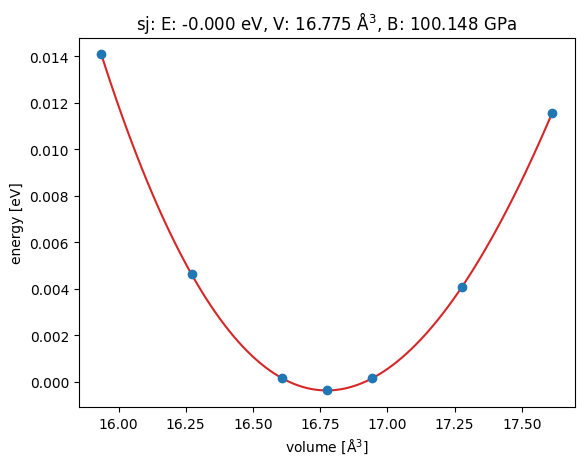

In [172]:
atoms = bulk("Ag", "fcc", 4)
structure = AseAtomsAdaptor().get_structure(atoms)
maker_fullopt = OptimizeJob()
job1 = maker_fullopt.make(structure=structure)
job2 = get_ev_curve(structure=job1.output["optimized_structure"])
job3 = get_results_ev_curve(list_structures=job2.output["optimized_structures"], list_energies=job2.output["energies"])
flow = Flow([job1, job2, job3], output=job3.output)

response = run_locally(flow)
print(response[flow.jobs[-1].uuid][1].output)

You have seen all basic functionalities to write workflows with jobflow.

#### Exercises
1. Please build a maker for the whole workflow! You can find an example here: [https://github.com/materialsproject/atomate2/blob/main/src/atomate2/vasp/flows/lobster.py](https://github.com/materialsproject/atomate2/blob/main/src/atomate2/vasp/flows/lobster.py)
2. Then, use the maker for different structures (e.g., bcc structure type) or elements (e.g., Al or other elements that work with EMT).

## Workflow to Compute Phonons (Vibrational Properties of Crystals)

### Introduction


We will now write a workflow to compute phonons with [Phonopy](https://phonopy.github.io/phonopy/). We will only compute phonon densities of states and not phonon band structures. It is possible to implement this. However, this is significantly more work and does not help you to learn about the automation itself. If you would like to try this, everything needed is implemented in pymatgen but this is really a more advanced task. Again, we will use the EMT calculator to speed up the calculations.

### Install Phonopy

We need to install phonopy.

In [173]:
%%capture
!pip install phonopy

### Workflow Structure

We will compute phonons with the finite differences approach which implemented in Phonopy. You can check out this reference in case you are interested: [https://onlinelibrary.wiley.com/doi/10.1002/anie.200906780](https://onlinelibrary.wiley.com/doi/10.1002/anie.200906780).

We will first optimize the crystal structure, then generate displaced structures and evaluate forces for the displaced structures. This will allow us to compute force constants for the whole unit cell. Those force constants can then be fourier-transformed to the dynamical matrix within Phonopy. This dynamical matrix will then be used to to get frequencies and eigenvalues describing the vibrations  (phonons) in the crystal structure.

We can reuse the `OptimizeJob` Maker from before for the structural optimization. We need a job that creates the displaced structures and one that starts the evaluations of the forces. This implies that we need an additional static job that just returns forces based on the displaced structure. At the very end, we need a job to summarize the job, create plots and return the results to a database. We will not implement the last job fully.

![workflow for phonons](workflow2.png)

### Compute Forces of Displaced Structures

Let's build a static job first that computes forces for a structure. The structure is very similar to the `OptimizeJob`

In [174]:
@dataclass
class StaticJob(Maker):
    """
    Class to compute energy and forces for a structure

    Parameters
    ----------
    name
        Name of the job.
    """
    name: str = "EMT-StaticRun"

    @job
    def make(self, structure: Structure):
        adaptor = AseAtomsAdaptor()
        atoms = adaptor.get_atoms(structure)
        atoms.calc = EMT()
        results = {}
        results["input_structure"] = structure
        results["energy"] = atoms.get_potential_energy()
        results["force"] = atoms.get_forces()
        return results



### Create Displaced Structures (Job)

Now, we need to build jobs that will create displacements for the finite displacement method based on an optimized `Structure`, run all static runs and then collect the results.

Let's start with the job that creates the displacements. It starts from an optimized structure and one can also define the size of the supercell matrix for the finite displacement approach:

In [175]:
from phonopy import Phonopy
from phonopy.units import VaspToTHz
from pymatgen.io.phonopy import (
    get_phonopy_structure,
    get_pmg_structure,
)


@job
def create_displacements(structure: Structure, supercell_matrix):
    factor = VaspToTHz  # we need this conversion factor. We will rely on eV
    cell = get_phonopy_structure(structure)  # this transforms the structure into a format that phonopy can use
    phonon = Phonopy(
        cell,
        supercell_matrix,  # we need to compute forces for displaced supercells of our initial structure
        factor=factor,
    )
    phonon.generate_displacements()  # phonopy will generate the displacements

    supercells = phonon.supercells_with_displacements  # these are all displaced structures

    displacements = []
    for icell in supercells:
        displacements.append(get_pmg_structure(icell))  # we will collect all structures in a pymatgen structure format

    return displacements

### Start Forces Computations (Job)

Now, we will generate static jobs for all generated structures. It's important to remember again that the outputs contain references. You can store the output references in a list or dictionary, but you cannot perform a numerical operation on the outputs before the job has been executed. In the next job, we will be able to resolve the displaced output structures from the previous jobs, but cannot perform any numerical operation on the forces from the static jobs as these computations still have to be performed. This has to be done in an additional job.

In [176]:
@job
def run_displacements(displacements):
    static_maker = StaticJob()
    runs = []
    forces = []
    for displacement in displacements:
        displacement_run = static_maker.make(displacement)
        forces.append(displacement_run.output[
                          "force"])  # this is possible but you cannot transform the array to a numpy array yet as the static_maker jobs haven't been run yet!
        runs.append(displacement_run)

    output = {"forces": forces}  #we will collect all forces from the runs.

    return Response(replace=Flow(runs, output))

### Plots and Summary (Job)

Now, we will write a job that evaluates all results. We again need to recreate the correct phonopy settings. Then, we use the plotting tools from pymatgen to plot the phonon density of states.

In [177]:
from pymatgen.phonon.plotter import PhononDosPlotter
from pymatgen.io.phonopy import (
    get_ph_dos
)


@job
def summarize_phonopy_results(structure: Structure, forces, supercell_matrix, kpoints=[10, 10, 10]):
    forces_set = []
    for force in forces:
        forces_set.append(np.array(force))

    factor = VaspToTHz
    cell = get_phonopy_structure(structure)
    phonon = Phonopy(
        cell,
        supercell_matrix,
        factor=factor,
    )
    phonon.generate_displacements()
    phonon.produce_force_constants(forces=forces_set)
    phonon.save("phonopy.yaml")
    phonon.run_mesh(kpoints)
    phonon.run_total_dos()
    phonon.write_total_dos(filename="phonon_dos.yaml")
    dos = get_ph_dos("phonon_dos.yaml")
    new_plotter_dos = PhononDosPlotter()
    new_plotter_dos.add_dos(label="total", dos=dos)
    new_plotter_dos.save_plot(filename="phonon_dos.eps")
    return {"PhononDOS": dos}

### Workflow

Now we connect the jobs with a structural optimization.

2023-06-05 09:09:42,346 INFO Started executing jobs locally
2023-06-05 09:09:42,352 INFO Starting job - EMT-Optimization (f7db9a8e-8a4c-4d6e-bd5f-361c79d810d5)
2023-06-05 09:09:42,594 INFO Finished job - EMT-Optimization (f7db9a8e-8a4c-4d6e-bd5f-361c79d810d5)
2023-06-05 09:09:42,595 INFO Starting job - create_displacements (59523ce9-e8c2-48b0-9b69-65febbb8f0b2)
2023-06-05 09:09:42,764 INFO Finished job - create_displacements (59523ce9-e8c2-48b0-9b69-65febbb8f0b2)
2023-06-05 09:09:42,769 INFO Starting job - run_displacements (d986aa7a-3900-4c93-b854-9c9015d4f781)
2023-06-05 09:09:42,794 INFO Finished job - run_displacements (d986aa7a-3900-4c93-b854-9c9015d4f781)
2023-06-05 09:09:42,799 INFO Starting job - EMT-StaticRun (29e7f2c5-fd58-4dee-8174-078ce5b4e9ec)
2023-06-05 09:09:42,835 INFO Finished job - EMT-StaticRun (29e7f2c5-fd58-4dee-8174-078ce5b4e9ec)
2023-06-05 09:09:42,837 INFO Starting job - store_inputs (d986aa7a-3900-4c93-b854-9c9015d4f781, 2)
2023-06-05 09:09:42,841 INFO Finished

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2023-06-05 09:09:43,750 INFO Finished job - summarize_phonopy_results (f864f741-12f5-456d-afbb-66c801e23a9d)
2023-06-05 09:09:43,754 INFO Finished executing jobs locally


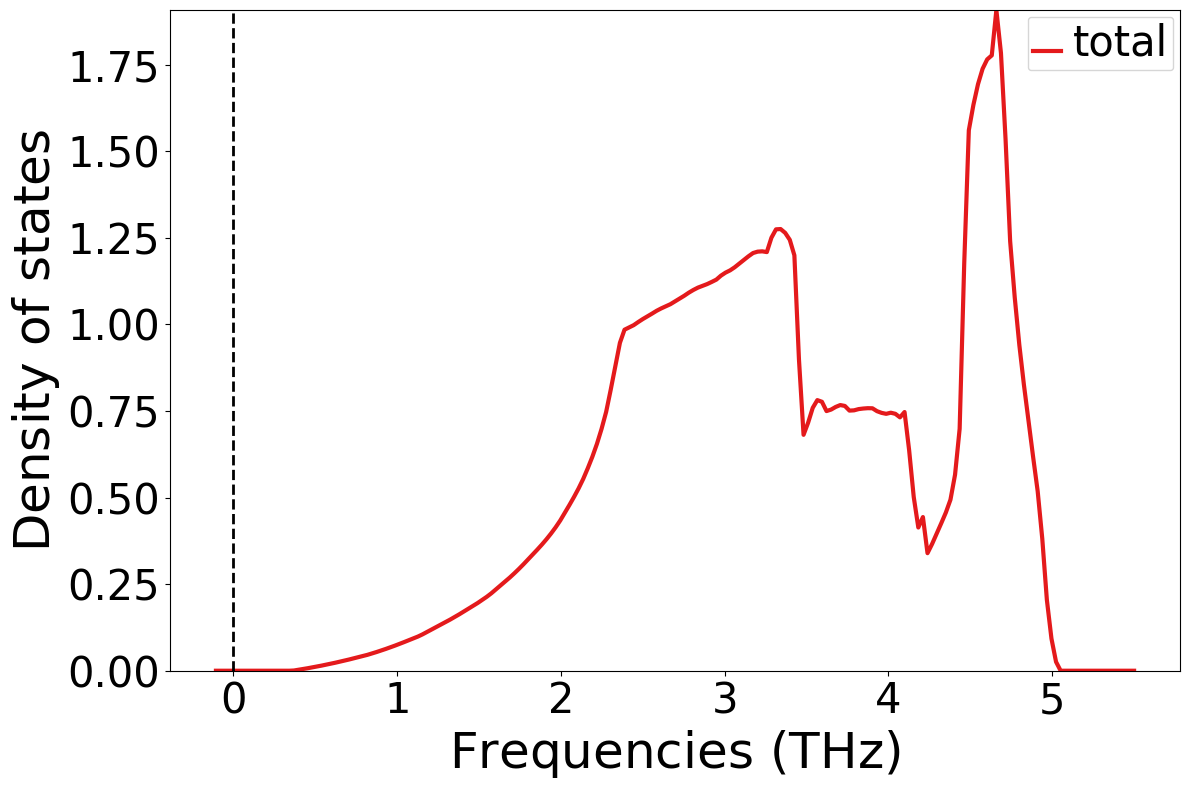

In [178]:
from jobflow.managers.local import run_locally
from jobflow import Flow
from ase.build import bulk

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.structure import Structure

atoms = bulk("Ag", "fcc", 3.9)
supercell_matrix = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
structure = AseAtomsAdaptor().get_structure(atoms)
maker_fullopt = OptimizeJob()
job1 = maker_fullopt.make(structure=structure)
job2 = create_displacements(structure=job1.output["optimized_structure"], supercell_matrix=supercell_matrix)
job3 = run_displacements(displacements=job2.output)
job4 = summarize_phonopy_results(structure=job1.output["optimized_structure"], forces=job3.output["forces"],
                                 supercell_matrix=supercell_matrix)
flow = Flow([job1, job2, job3, job4], output=job4.output)

response = run_locally(flow)

new_plotter_dos = PhononDosPlotter()
new_plotter_dos.add_dos(label="total", dos=response[flow.jobs[-1].uuid][1].output["PhononDOS"])
new_plotter_dos.show()



If you are interested in a full phonon workflow based on DFT, please check out the atomate2 implementation: [phonon workflow in atomate2](https://github.com/materialsproject/atomate2/blob/c2d098a38a41c181be2c483f8adb83db0223b76d/src/atomate2/vasp/flows/phonons.py#L35)

### Exercise
1. Please write a maker for the whole flow
2. Combine this new maker to a larger workflow. This new workflow will include three phonon runs. One will be performed at the fully optimized volume, one at a volume 1% larger, the other one at a volume 1% smaller than the fully optimized volume. This is a typical setting for computing Grüneisen parameters.
